# Laboratory practice № 9 (Linear Matrix Inequalities)

Done by Zolotarev Dmitriy (isu: 311791, group: R33353)

Variant: 9

## Preparation

In [44]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp

import seaborn as sns
sns.set_style("whitegrid")

color = ["#031B88", "#FB7B8E", "#AAB6FB", "#8A2BE2"]
sns.set_palette(color)

## Task 1

In [45]:
A = np.array([
    [-2, 0, 0, 0],
    [0, 3, 0, 0],
    [0, 0, 1, 3],
    [0, 0, -3, 1]
])

B = np.array([
    [0],
    [5],
    [0],
    [2]
])

In [46]:
np.linalg.eigvals(A)

array([ 1.+3.j,  1.-3.j, -2.+0.j,  3.+0.j])

In [47]:
alphas_1 = [0.2, 0.4, 1.6, 2]

In [48]:
def get_K_LMI(a, b, alpha):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[P >> np.eye(4), P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0])
    prob.solve()
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value) 

def get_K_LMI_mu(a, b, alpha, x0, mu=None):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    if mu is None:
        mu_ = cp.Variable((1,1))
    else:
        mu_ = mu
    sub1 = cp.bmat([
        [P, x0],
        [x0.T, [[1]]]
    ])
    if mu is None:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, mu_]
        ])
    else:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, [[mu_*mu_]]]
        ])
    res = prob = cp.Problem(cp.Maximize(0) if mu is not None else cp.Minimize(mu_),
                      [P >> np.eye(4), 
                       P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0,
                       sub1 >> 0, sub2 >> 0])
    prob.solve()
    print(P.value, Y.value)
    # print(prob)
    return Y.value @ np.linalg.inv(P.value), np.sqrt(res.value)

In [49]:
Ks_1 = [get_K_LMI(A,B,alph) for alph in alphas_1]
Ks_1

[array([[ 0.        , -1.90743798, -2.30540005,  1.17683538]]),
 array([[ 0.        , -2.23145711, -2.69352083,  1.69919906]]),
 array([[ 0.        , -3.73312904, -4.54312989,  3.51203587]]),
 array([[ 0.        , -4.53947861, -5.21710856,  5.01838697]])]

In [50]:
eig = [np.round(np.linalg.eigvals(A + B@K),3) for K in Ks_1]
eig

[array([-0.65 +4.313j, -0.65 -4.313j, -0.884+0.j   , -2.   +0.j   ]),
 array([-0.85 +4.574j, -0.85 -4.574j, -1.058+0.j   , -2.   +0.j   ]),
 array([-2.209+4.395j, -2.209-4.395j, -2.223+0.j   , -2.   +0.j   ]),
 array([-2.579+4.743j, -2.579-4.743j, -2.503+0.j   , -2.   +0.j   ])]

In [51]:
systems_1 = [ctrl.ss(A + B@K,np.zeros((4,1)),np.zeros((1,4)),0) for K in Ks_1]
time_1 = np.linspace(0,10,int(10/0.001))
ys_1 = [ctrl.initial_response(sys,time_1,X0=np.array([1, 2, 1, 2])) for sys in systems_1]

In [52]:
ys_1[0].states

array([[ 1.00000000e+00,  9.98001799e-01,  9.96007591e-01, ...,
         2.06941558e-09,  2.06528047e-09,  2.06115362e-09],
       [ 2.00000000e+00,  1.98714224e+00,  1.97423778e+00, ...,
         6.25828029e-03,  6.25919942e-03,  6.25999461e-03],
       [ 1.00000000e+00,  1.00699138e+00,  1.01396404e+00, ...,
        -1.50525438e-03, -1.49423840e-03, -1.48320694e-03],
       [ 2.00000000e+00,  1.99144950e+00,  1.98286627e+00, ...,
         4.17076969e-03,  4.17229774e-03,  4.17374360e-03]])

States

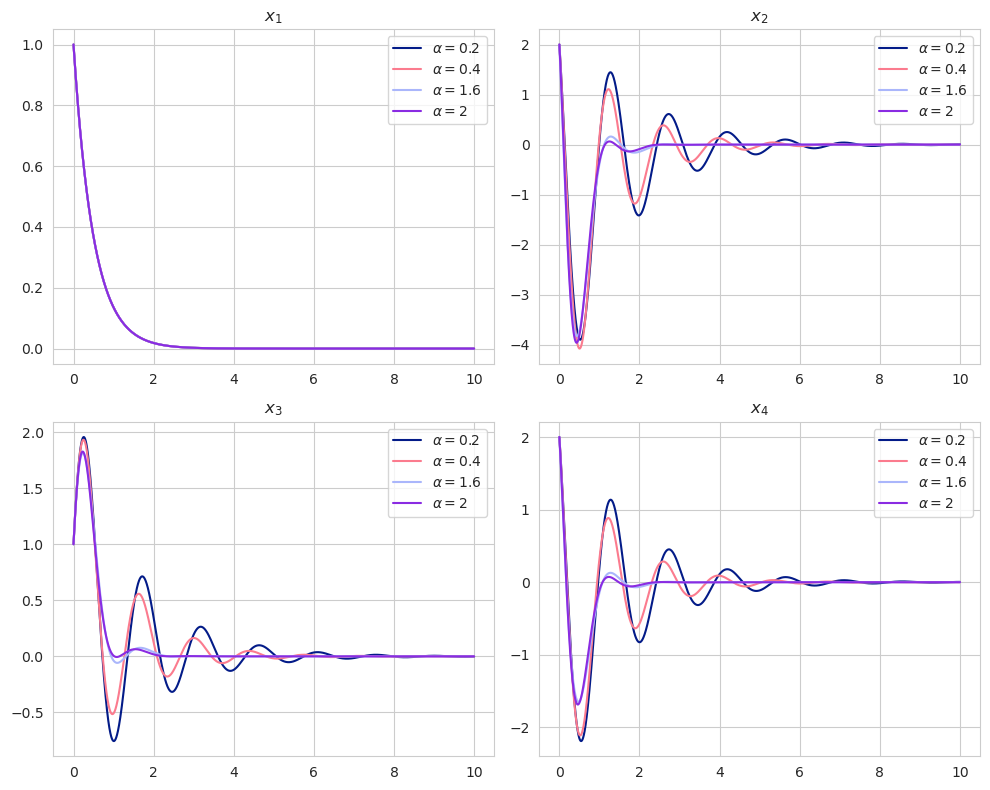

In [53]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        for y_i in range(len(ys_1)):
            ax[i,j].plot(time_1,ys_1[y_i].states[i*2 + j,:],label=f"$\\alpha={alphas_1[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

plt.tight_layout()

Input signal

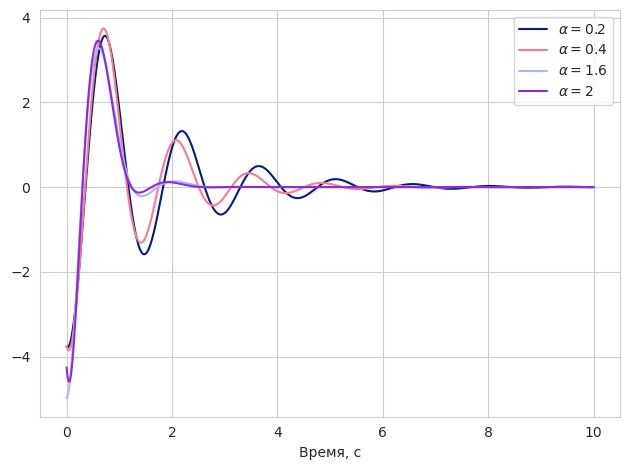

In [54]:
for y_i in range(len(ys_1)):
    plt.plot(time_1,(Ks_1[y_i]@ys_1[y_i].states).reshape(-1),label=f"$\\alpha={alphas_1[y_i]}$")
plt.grid(True)
plt.legend()
plt.xlabel("Время, с")
plt.tight_layout()

## Task 2

In [55]:
X_0 = np.array([
    [1],
    [2],
    [1],
    [2]
])

Minimizing

In [56]:
alphas_1

[0.2, 0.4, 1.6, 2]

In [57]:
Ks_mus_2 = [get_K_LMI_mu(A,B,alpha,X_0) for alpha in alphas_1]
Ks_mus_2

[[ 7.01460207e+02  6.89747654e-01  3.72623966e-01  5.38080495e-01]
 [ 6.89747654e-01  1.95970669e+01 -6.79686930e+00  1.11444355e+01]
 [ 3.72623966e-01 -6.79686930e+00  6.17782506e+00 -2.46936990e+00]
 [ 5.38080495e-01  1.11444355e+01 -2.46936990e+00  8.62166511e+00]] [[ -0.82389968 -12.54175541  -0.70415893  -8.87172907]]
[[ 9.56685064e+02  2.15954430e-01  4.35696708e-01  4.38667705e-01]
 [ 2.15954430e-01  2.60364093e+01 -8.78441155e+00  1.32791305e+01]
 [ 4.35696708e-01 -8.78441155e+00  6.54395399e+00 -3.05472198e+00]
 [ 4.38667705e-01  1.32791305e+01 -3.05472198e+00  9.08062669e+00]] [[ -0.5965209  -17.70479589   0.46703526 -10.93811867]]
[[ 1.80521177e+02  1.02355482e-03 -3.49592174e-04  3.34048074e-04]
 [ 1.02355482e-03  1.24455278e+02 -3.23079645e+01  5.34762655e+01]
 [-3.49592174e-04 -3.23079645e+01  1.38600908e+01 -1.20121193e+01]
 [ 3.34048074e-04  5.34762655e+01 -1.20121193e+01  2.50560333e+01]] [[-9.39716997e-04 -1.14498870e+02  1.44376711e+01 -5.05910345e+01]]
[[ 2.93915273

[(array([[ 6.15430554e-04, -1.14084229e+00, -1.34504369e+00,
           6.03796016e-02]]),
  3.8344040104957706),
 (array([[ 3.26068610e-04, -1.30412748e+00, -1.60306555e+00,
           1.63259398e-01]]),
  4.532018994046747),
 (array([[-1.50485665e-07, -3.02445630e+00, -3.70209783e+00,
           2.66105779e+00]]),
  12.57887700648341),
 (array([[ 1.34951398e-09, -3.87190981e+00, -4.43594549e+00,
           4.17974217e+00]]),
  16.87699780388714)]

In [58]:
get_K_LMI_mu(A,B,0.4,X_0,5)

[[ 1.37207522e+03  2.82520356e-01  4.60349982e-01  4.70389475e-01]
 [ 2.82520356e-01  3.07212677e+01 -1.04197621e+01  1.57057604e+01]
 [ 4.60349982e-01 -1.04197621e+01  7.63977581e+00 -3.60772648e+00]
 [ 4.70389475e-01  1.57057604e+01 -3.60772648e+00  1.06455038e+01]] [[ -0.70596173 -20.90022507   0.56588203 -12.94265862]]


(array([[ 2.52632198e-04, -1.38233740e+00, -1.69335138e+00,
          2.49751822e-01]]),
 0.0)

In [59]:
eig = [np.round(np.linalg.eigvals(A + B@K_mu[0]),3) for K_mu in Ks_mus_2]
eig

[array([-0.197+3.61j, -0.197-3.61j, -0.189+0.j  , -2.   +0.j  ]),
 array([-0.399+3.662j, -0.399-3.662j, -0.396+0.j   , -2.   +0.j   ]),
 array([-1.6+4.645j, -1.6-4.645j, -1.6+0.j   , -2. +0.j   ]),
 array([-2.+5.033j, -2.-5.033j, -2.+0.j   , -2.+0.j   ])]

In [60]:
systems_2 = [ctrl.ss(A + B@K_mu[0],np.zeros((4,1)),np.zeros((1,4)),0) for K_mu in Ks_mus_2]
time_2 = np.linspace(0,10,int(10/0.001))
ys_2 = [ctrl.initial_response(sys,time_2,X0=np.ones((4,1))) for sys in systems_2]

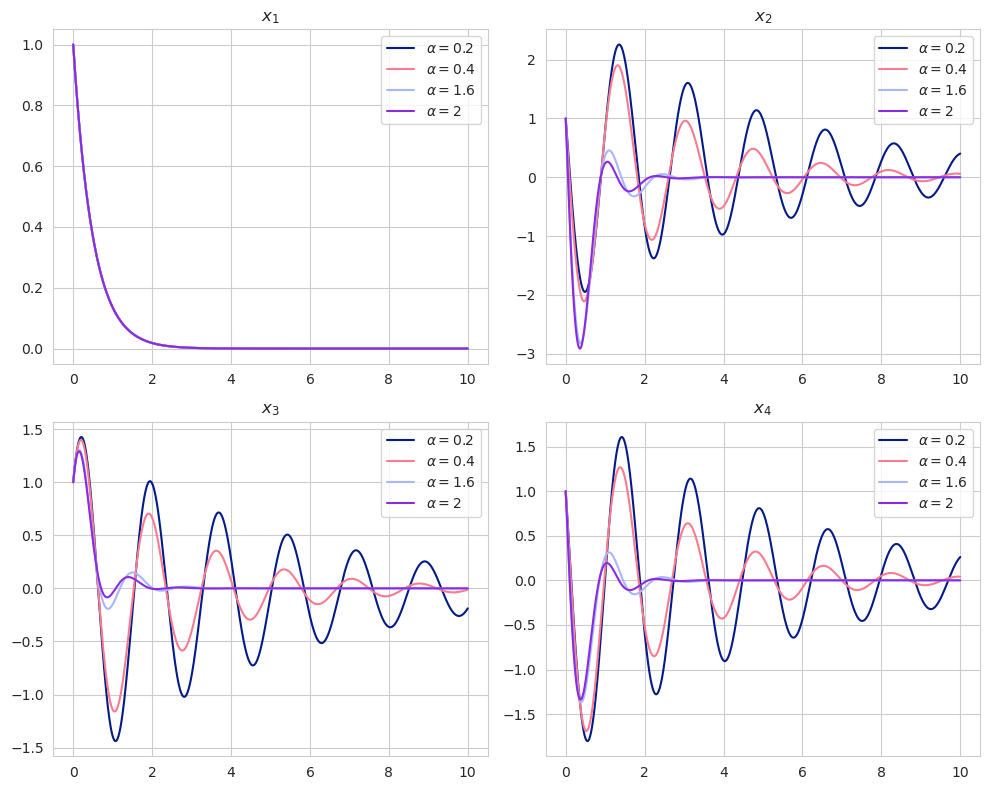

In [61]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        for y_i in range(len(ys_2)):
            ax[i,j].plot(time_1,ys_2[y_i].states[i*2 + j,:],label=f"$\\alpha={alphas_1[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

plt.tight_layout()

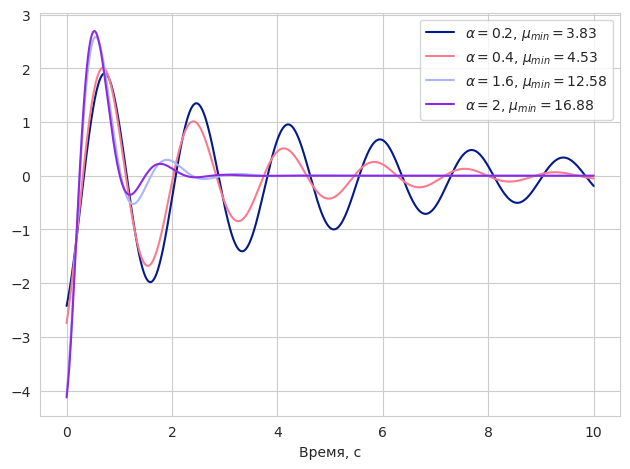

In [62]:
for y_i in range(len(ys_2)):
    plt.plot(time_2,(Ks_mus_2[y_i][0]@ys_2[y_i].states).reshape(-1),label=f"$\\alpha={alphas_1[y_i]}$, $\\mu_{'{min}'}={round(Ks_mus_2[y_i][1],2)}$")
plt.grid(True)
plt.xlabel("Время, с")
plt.legend()
plt.tight_layout()

Bound the input signal

In [63]:
mus_2 = [40, 20, 10, 5]
Ks_2 = [get_K_LMI_mu(A,B,0.4,X_0,mus_2[mu_i])[0] for mu_i in range(len(mus_2))]
Ks_2

[[8576.11702739   45.70880118   64.74031432   54.64367005]
 [  45.70880118 1597.43002732 -496.99951135 1154.24754257]
 [  64.74031432 -496.99951135  510.36914492 -238.31075285]
 [  54.64367005 1154.24754257 -238.31075285  876.84844188]] [[  -95.11648099 -1086.81609358  -214.99625089  -972.68417372]]
[[5678.52409215   12.09639176   14.80923323   13.10454852]
 [  12.09639176  422.01347594 -123.07191464  267.83314738]
 [  14.80923323 -123.07191464  115.08106071  -53.72296753]
 [  13.10454852  267.83314738  -53.72296753  193.62621595]] [[ -23.79808834 -287.02481437  -42.51198345 -216.25433598]]
[[ 2.45076087e+03  1.53523308e+00  4.18794012e+00  3.31362121e+00]
 [ 1.53523308e+00  1.05409658e+02 -3.53451882e+01  7.22502999e+01]
 [ 4.18794012e+00 -3.53451882e+01  3.37079658e+01 -1.57382483e+01]
 [ 3.31362121e+00  7.22502999e+01 -1.57382483e+01  5.46788176e+01]] [[ -4.8551877  -71.68523274  -9.41433324 -61.9049422 ]]
[[ 1.37207522e+03  2.82520356e-01  4.60349982e-01  4.70389475e-01]
 [ 2.82520

[array([[ 0.00702861, -1.38613123, -1.64718368,  0.26723972]]),
 array([[ 0.00241814, -1.35956588, -1.68554542,  0.29592213]]),
 array([[ 1.36132768e-03, -1.29006852e+00, -1.57684177e+00,
          1.18540549e-01]]),
 array([[ 2.52632198e-04, -1.38233740e+00, -1.69335138e+00,
          2.49751822e-01]])]

In [64]:
eig = [np.round(np.linalg.eigvals(A + B@K),3) for K in Ks_2]
eig

[array([-0.404+3.677j, -0.404-3.677j, -0.589+0.j   , -2.   +0.j   ]),
 array([-0.402+3.795j, -0.402-3.795j, -0.403+0.j   , -2.   +0.j   ]),
 array([-0.401+3.608j, -0.401-3.608j, -0.41 +0.j   , -2.   +0.j   ]),
 array([-0.449+3.697j, -0.449-3.697j, -0.515+0.j   , -2.   +0.j   ])]

In [65]:
systems_2_ = [ctrl.ss(A + B@K,np.zeros((4,1)),np.zeros((1,4)),0) for K in Ks_2]
time_2_ = np.linspace(0,10,int(10/0.001))
ys_2_ = [ctrl.initial_response(sys,time_2_,X0=np.ones((4,1))) for sys in systems_2_]

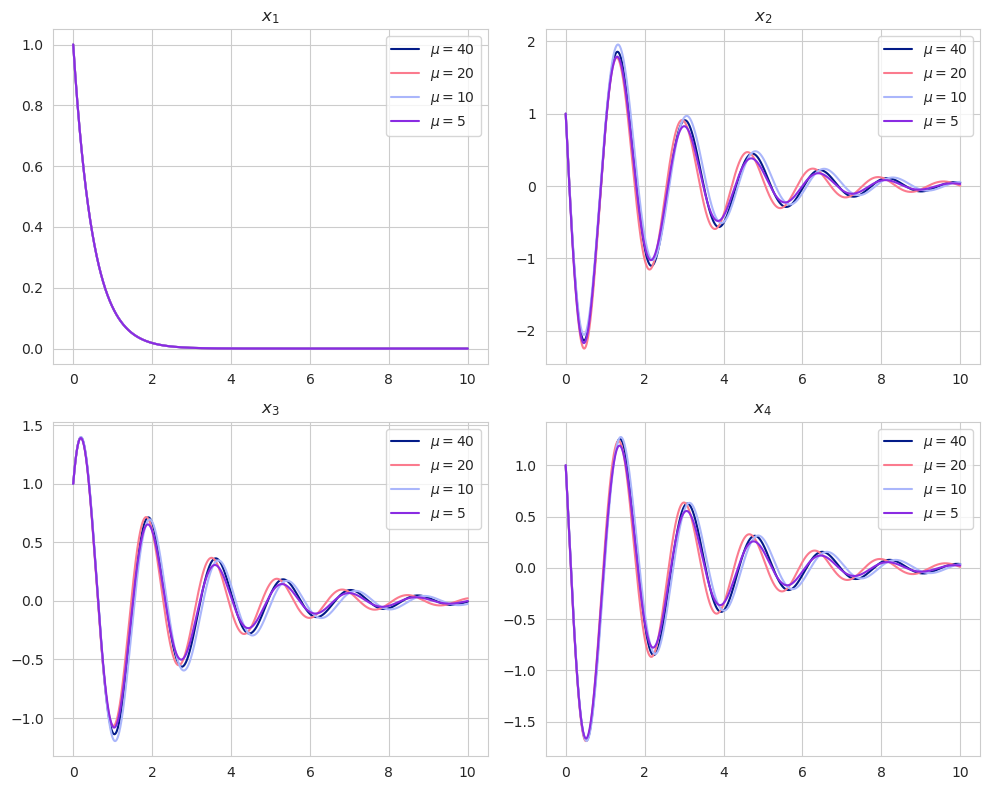

In [66]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        for y_i in range(len(ys_2_)):
            ax[i,j].plot(time_2_,ys_2_[y_i].states[i*2 + j,:],label=f"$\\mu={mus_2[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()

plt.tight_layout()

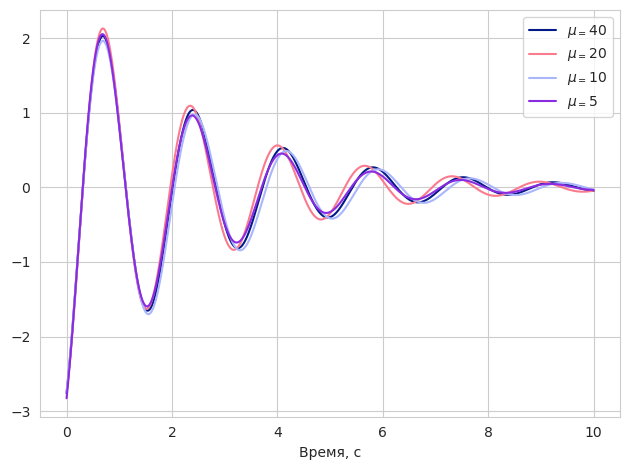

In [67]:
for y_i in range(len(ys_2_)):
    plt.plot(time_2_,(Ks_2[y_i]@ys_2_[y_i].states).reshape(-1),label=f"$\\mu_={round(mus_2[y_i],2)}$")
plt.grid(True)
plt.xlabel("Время, с")
plt.legend()
plt.tight_layout()

## Task 3

In [102]:
A = np.array([
    [0, 2, 0 ,0],
    [-2, 0, 0, 0],
    [0, 0, 0, 4],
    [0, 0, -4, 0]
])
C = np.array([0, 3, 2, 0]).reshape((1,-1))

In [103]:
def get_L_LMI(a, c, alpha):
    Q = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((c.shape[1],c.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[Q >> np.eye(4), 
                                      a.T@Q + Q@A + 2*alpha*Q + c.T@Y.T + Y@c << 0])
    prob.solve()
    # print(Q.value, Y.value)
    return np.linalg.inv(Q.value) @ Y.value


In [104]:
alphas_2 = [0.5, 1, 2, 4]

In [105]:
Ls = [get_L_LMI(A,C,alpha) for  alpha in alphas_2]

for l in Ls:
    print("{} & {} & {} & {}".format(*np.round(l.reshape(-1),2)))

0.05 & -0.6 & -0.43 & -0.69
0.65 & -2.68 & 0.88 & -3.09
4.33 & -9.13 & 8.52 & -6.63
65.18 & -59.16 & 78.44 & 10.28


In [106]:
eig = [np.round(np.linalg.eigvals(A + L@C),3) for L in Ls]
for l in eig:
    print("{}, {}, {}, {}".format(*np.round(l.reshape(-1),2)))

(-0.66+2.06j), (-0.66-2.06j), (-0.65+4.36j), (-0.65-4.36j)
(-1.57+2.16j), (-1.57-2.16j), (-1.57+5.4j), (-1.57-5.4j)
(-2.63+7.34j), (-2.63-7.34j), (-2.55+2.21j), (-2.55-2.21j)
(-5.41+12.74j), (-5.41-12.74j), (-4.89+2.72j), (-4.89-2.72j)


In [124]:
system_3 = ctrl.ss(A, [[0]]*4,C,0)
systems_3_obs = [ctrl.ss(A + L@C,-L,C,0) for L in Ls]
time_3 = np.linspace(0,6,int(7/0.001))
y_3 = ctrl.initial_response(system_3,time_3,X0=np.ones((4,1)))
ys_3_obs = [ctrl.forced_response(sys_obs,time_3,X0=np.array([[2],[0],[0],[-1]]),U=y_3.outputs) for sys_obs in systems_3_obs]

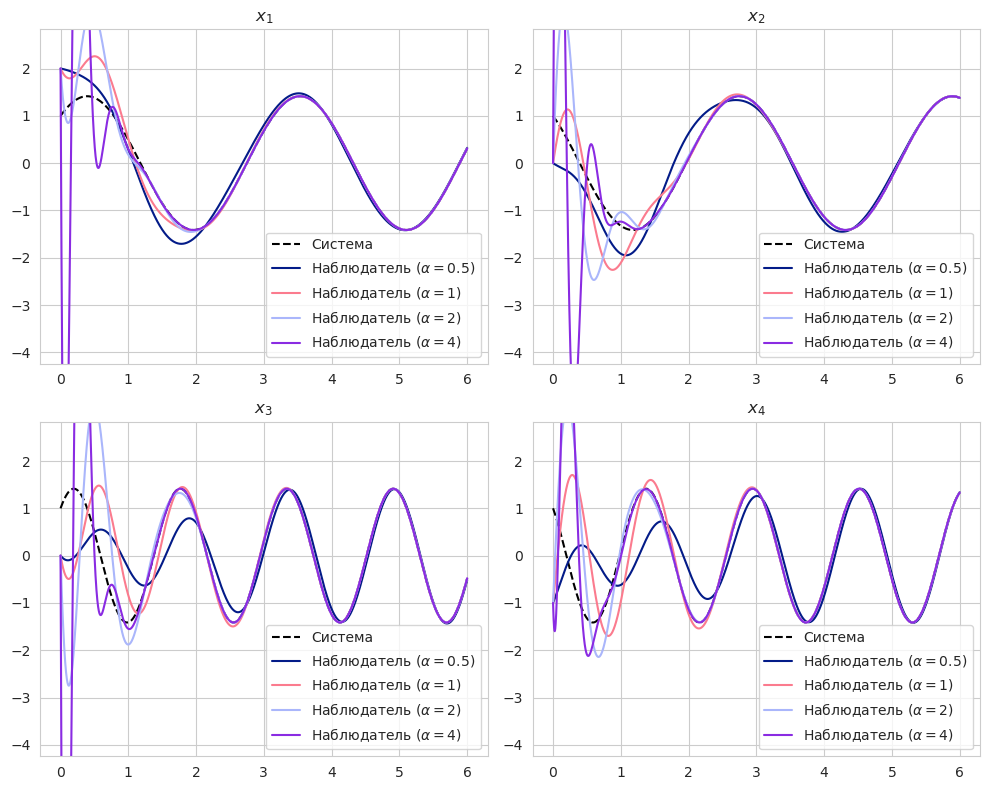

In [125]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$x_{i*2 + j+1}$")
        ax[i,j].plot(time_3,y_3.states[i*2 + j,:], color="black", linestyle="--",label=f"Система")
        ax[i,j].set_ylim([3*np.min(y_3.states[i*2 + j,:]),2*np.max(y_3.states[i*2 + j,:])])
        for y_i in range(len(ys_3_obs)):
            ax[i,j].plot(time_3,ys_3_obs[y_i].states[i*2 + j,:],label=f"Наблюдатель ($\\alpha={alphas_2[y_i]}$)")
        ax[i,j].grid(True)
        ax[i,j].legend()
plt.tight_layout()

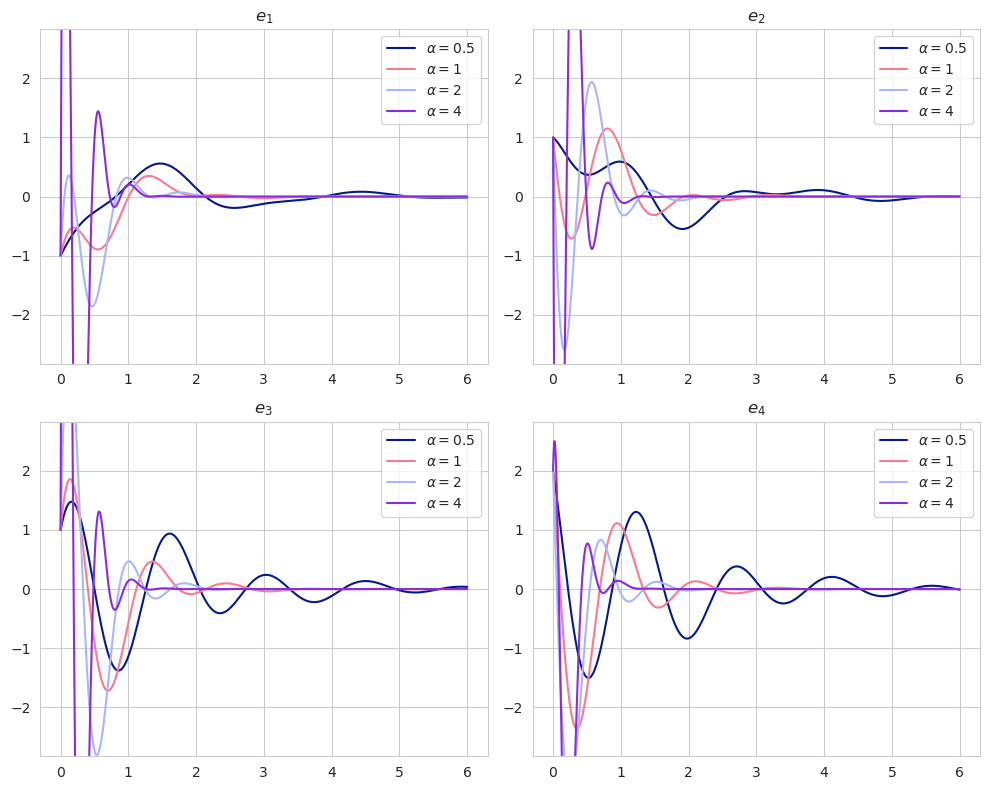

In [126]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(f"$e_{i*2 + j+1}$")
        ax[i,j].set_ylim([2*np.min(y_3.states[i*2 + j,:]),2*np.max(y_3.states[i*2 + j,:])])
        for y_i in range(len(ys_3_obs)):
            ax[i,j].plot(time_3,y_3.states[i*2 + j,:] - ys_3_obs[y_i].states[i*2 + j,:],label=f"$\\alpha={alphas_2[y_i]}$")
        ax[i,j].grid(True)
        ax[i,j].legend()
plt.tight_layout()

## Task 4

In [127]:
A = np.array([
    [2, 0, -4, 2],
    [0, 2, -2, 4],
    [-4, -2, 2, 0],
    [2, 4, 0, 2]
])
B = np.array([
    [8],
    [6],
    [4],
    [2]
])
C = np.array([
    [2, 0, 0, 2],
    [-1, 1, 1, 1]
])

In [128]:
alpha_sys = 2
alphas_obs = [1, 2, 3]

In [129]:
K = get_K_LMI(A, B, 2)
Ls = [get_L_LMI(A, C, alpha) for alpha in alphas_obs]

In [130]:
As_new = [np.block([
    [A + B@K, -B@K],
    [np.zeros_like(A), A + L@C]
]) for L in Ls]

In [131]:
systems_4 = [ctrl.ss(A_new,np.zeros((8,1)),np.zeros((1,8)),0) for A_new in As_new]
time_4 = np.linspace(0,3,int(3/0.001))
ys_4 = [ctrl.initial_response(sys,T=time_4,X0=[-1,-1,-1,-1,2,2,2,2]) for sys in systems_4]

obs < cont

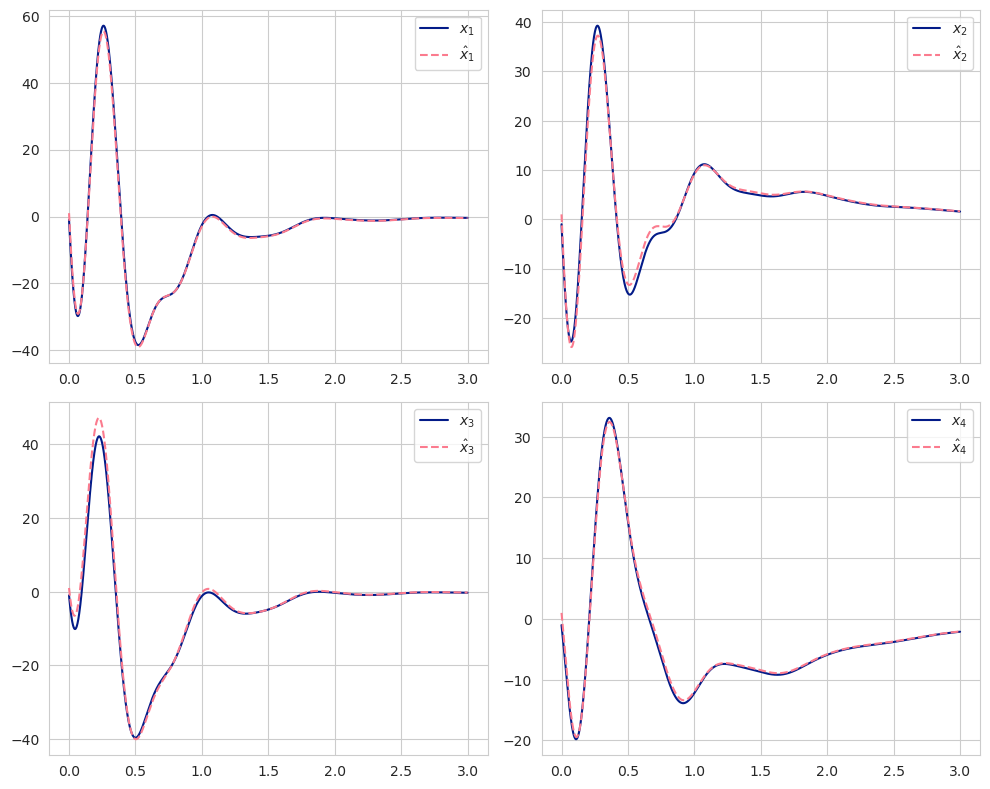

In [140]:
y = ys_4[0]
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(time_4,y.states[0,:],label="$x_1$")
ax[0,0].plot(time_4,y.states[0,:]+y.states[4,:],linestyle="--",label="$\hat{x}_1$")
ax[0,0].legend()
ax[0,0].grid(True)
ax[0,1].plot(time_4,y.states[1,:],label="$x_2$")
ax[0,1].plot(time_4,y.states[1,:]+y.states[5,:],linestyle="--",label="$\hat{x}_2$")
ax[0,1].legend()
ax[0,1].grid(True)
ax[1,0].plot(time_4,y.states[2,:],label="$x_3$")
ax[1,0].plot(time_4,y.states[2,:]+y.states[6,:],linestyle="--",label="$\hat{x}_3$")
ax[1,0].legend()
ax[1,0].grid(True)
ax[1,1].plot(time_4,y.states[3,:],label="$x_4$")
ax[1,1].plot(time_4,y.states[3,:]+y.states[7,:],linestyle="--",label="$\hat{x}_4$")
ax[1,1].legend()
ax[1,1].grid(True)
plt.tight_layout()

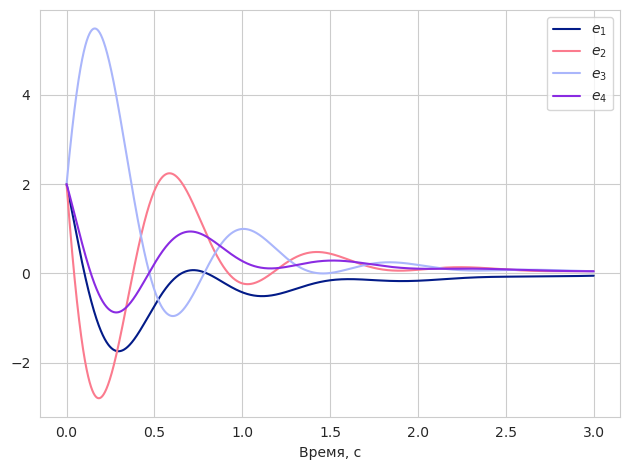

In [141]:
plt.plot(time_4,y.states[4,:],label="$e_1$")
plt.plot(time_4,y.states[5,:],label="$e_2$")
plt.plot(time_4,y.states[6,:],label="$e_3$")
plt.plot(time_4,y.states[7,:],label="$e_4$")
plt.legend()
plt.grid(True)
plt.xlabel("Время, с")
plt.tight_layout()

obs = cont

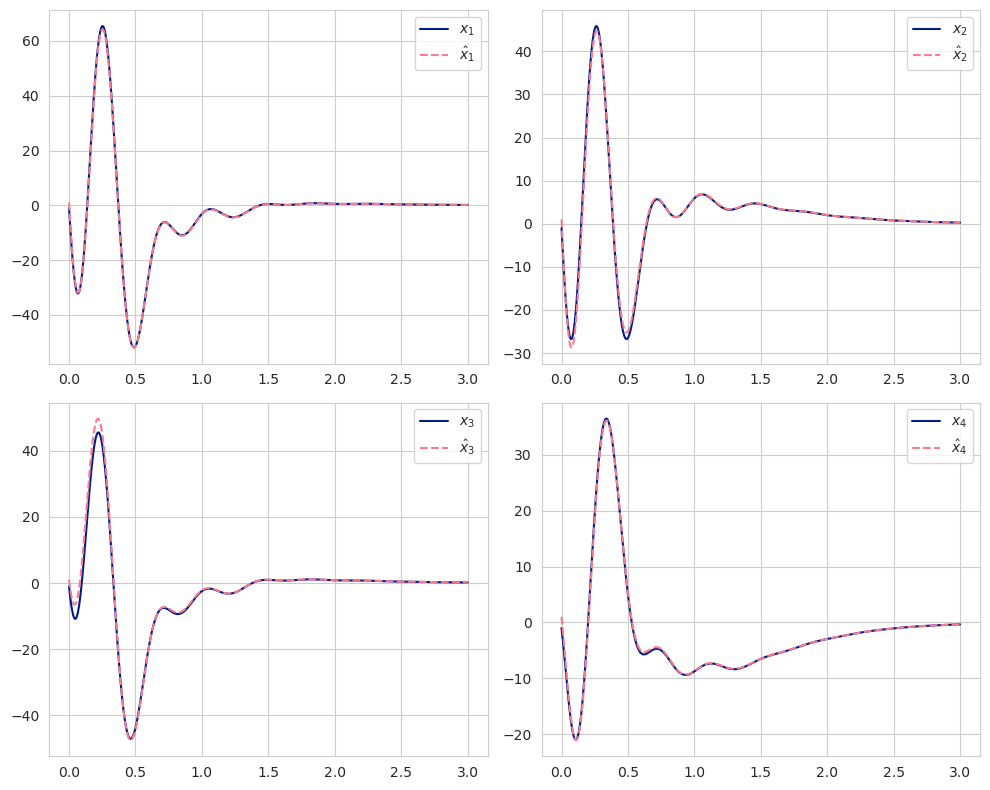

In [142]:
y = ys_4[1]
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(time_4,y.states[0,:],label="$x_1$")
ax[0,0].plot(time_4,y.states[0,:]+y.states[4,:],linestyle="--",label="$\hat{x}_1$")
ax[0,0].legend()
ax[0,0].grid(True)
ax[0,1].plot(time_4,y.states[1,:],label="$x_2$")
ax[0,1].plot(time_4,y.states[1,:]+y.states[5,:],linestyle="--",label="$\hat{x}_2$")
ax[0,1].legend()
ax[0,1].grid(True)
ax[1,0].plot(time_4,y.states[2,:],label="$x_3$")
ax[1,0].plot(time_4,y.states[2,:]+y.states[6,:],linestyle="--",label="$\hat{x}_3$")
ax[1,0].legend()
ax[1,0].grid(True)
ax[1,1].plot(time_4,y.states[3,:],label="$x_4$")
ax[1,1].plot(time_4,y.states[3,:]+y.states[7,:],linestyle="--",label="$\hat{x}_4$")
ax[1,1].legend()
ax[1,1].grid(True)
plt.tight_layout()

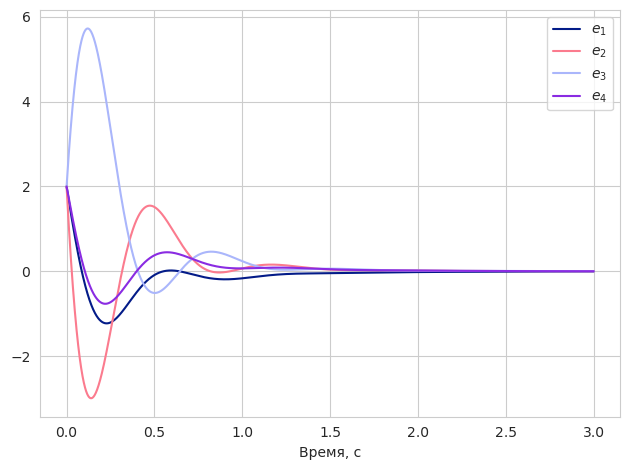

In [143]:
plt.plot(time_4,y.states[4,:],label="$e_1$")
plt.plot(time_4,y.states[5,:],label="$e_2$")
plt.plot(time_4,y.states[6,:],label="$e_3$")
plt.plot(time_4,y.states[7,:],label="$e_4$")
plt.legend()
plt.xlabel("Время, с")
plt.grid(True)
plt.tight_layout()

obs > cont

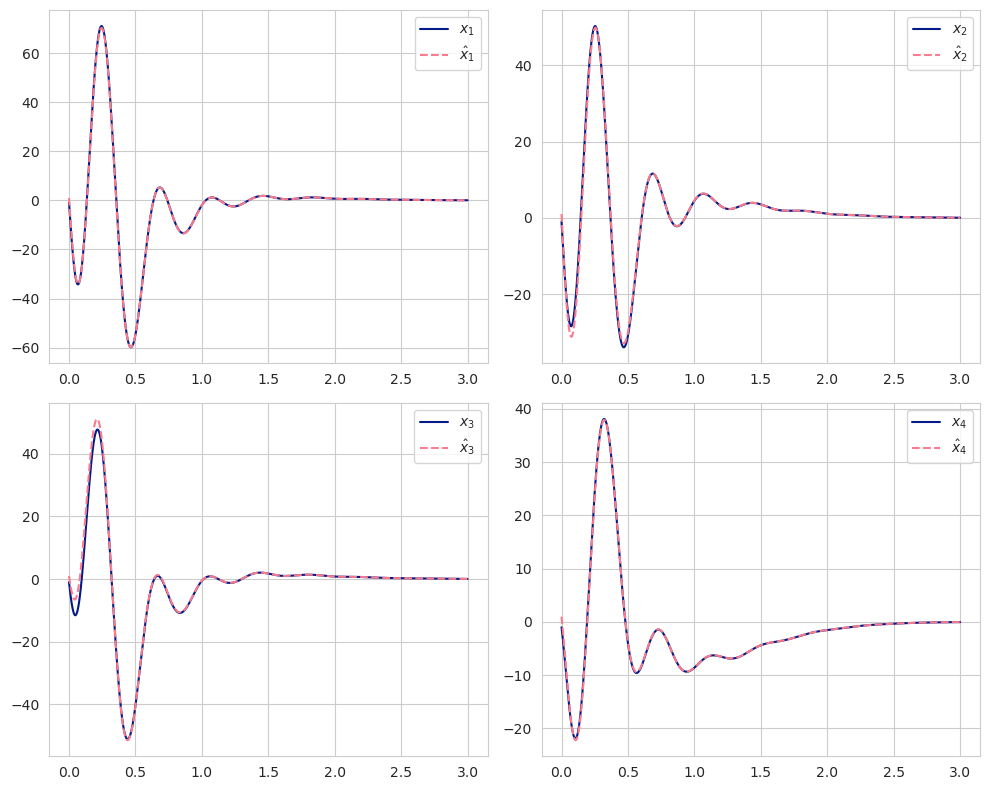

In [144]:
y = ys_4[2]
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(time_4,y.states[0,:],label="$x_1$")
ax[0,0].plot(time_4,y.states[0,:]+y.states[4,:],linestyle="--",label="$\hat{x}_1$")
ax[0,0].legend()
ax[0,0].grid(True)
ax[0,1].plot(time_4,y.states[1,:],label="$x_2$")
ax[0,1].plot(time_4,y.states[1,:]+y.states[5,:],linestyle="--",label="$\hat{x}_2$")
ax[0,1].legend()
ax[0,1].grid(True)
ax[1,0].plot(time_4,y.states[2,:],label="$x_3$")
ax[1,0].plot(time_4,y.states[2,:]+y.states[6,:],linestyle="--",label="$\hat{x}_3$")
ax[1,0].legend()
ax[1,0].grid(True)
ax[1,1].plot(time_4,y.states[3,:],label="$x_4$")
ax[1,1].plot(time_4,y.states[3,:]+y.states[7,:],linestyle="--",label="$\hat{x}_4$")
ax[1,1].legend()
ax[1,1].grid(True)
plt.tight_layout()

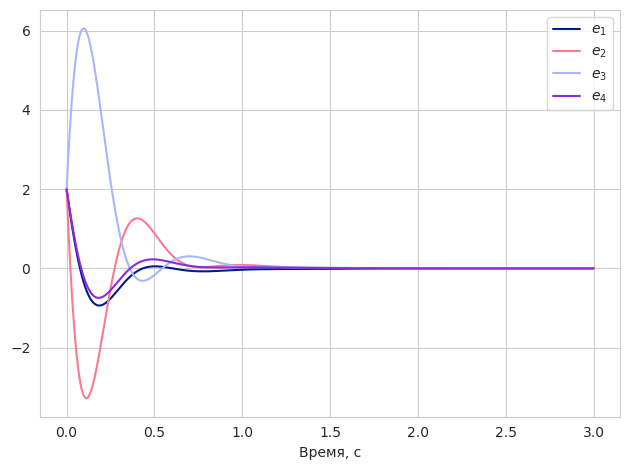

In [145]:
plt.plot(time_4,y.states[4,:],label="$e_1$")
plt.plot(time_4,y.states[5,:],label="$e_2$")
plt.plot(time_4,y.states[6,:],label="$e_3$")
plt.plot(time_4,y.states[7,:],label="$e_4$")
plt.legend()
plt.grid(True)
plt.xlabel("Время, с")
plt.tight_layout()